# Промышленность — задача проекта

Чтобы оптимизировать производственные расходы, металлургический комбинат ООО «Так закаляем сталь» решил уменьшить потребление электроэнергии на этапе обработки стали. Вам предстоит построить модель, которая предскажет температуру стали.

 **Описание этапа обработки**

Сталь обрабатывают в металлическом ковше вместимостью около 100 тонн. Чтобы ковш выдерживал высокие температуры, изнутри его облицовывают огнеупорным кирпичом. Расплавленную сталь заливают в ковш и подогревают до нужной температуры графитовыми электродами. Они установлены в крышке ковша. 

Из сплава выводится сера (десульфурация), добавлением примесей корректируется химический состав и отбираются пробы. Сталь легируют — изменяют её состав — подавая куски сплава из бункера для сыпучих материалов или проволоку через специальный трайб-аппарат (англ. tribe, «масса»).

Перед тем как первый раз ввести легирующие добавки, измеряют температуру стали и производят её химический анализ. Потом температуру на несколько минут повышают, добавляют легирующие материалы и продувают сплав инертным газом. Затем его перемешивают и снова проводят измерения. Такой цикл повторяется до достижения целевого химического состава и оптимальной температуры плавки.

Тогда расплавленная сталь отправляется на доводку металла или поступает в машину непрерывной разливки. Оттуда готовый продукт выходит в виде заготовок-слябов (англ. *slab*, «плита»).
 
 **Описание данных**

Данные состоят из файлов, полученных из разных источников:

- `data_arc_new.csv` — данные об электродах;
- `data_bulk_new.csv` — данные о подаче сыпучих материалов (объём);
- `data_bulk_time_new.csv` *—* данные о подаче сыпучих материалов (время);
- `data_gas_new.csv` — данные о продувке сплава газом;
- `data_temp_new.csv` — результаты измерения температуры;
- `data_wire_new.csv` — данные о проволочных материалах (объём);
- `data_wire_time_new.csv` — данные о проволочных материалах (время).

Во всех файлах столбец `key` содержит номер партии. В файлах может быть несколько строк с одинаковым значением `key`: они соответствуют разным итерациям обработки.

# План работы



Описание проекта, задачи

1. Первичный анализ данных:

* Выгрузка данных

* Анализ данных

* Вывод

2. Предобработка данных:

* Проверка типов данных

* Работа с проспусками

* Подготовка данных:

* Формирование итоговых датафреймов

* Проверка на мультиколлинеарность

* Формирвоание обучающей и тестовой выборок

* Формирование целевого и остальных признаков

* Вывод

3. Обучение моделей:

* LinearRegression
* RandomForestRegressor
* CatBoostRegressor

4. Тестирование моделей:

* Проверка модели на тестовой выборке
* Выбор ключевой модели
* Проверка модели на адекватность

5. Итоговый вывод

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import os

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.linear_model import SGDRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

In [3]:
import warnings
warnings.filterwarnings('ignore')

## Первичный анализ данных

In [4]:
arc = pd.read_csv('/datasets/data_arc_new.csv')
bulk = pd.read_csv('/datasets/data_bulk_new.csv')
bulk_time = pd.read_csv('/datasets/data_bulk_time_new.csv')
gas = pd.read_csv('/datasets/data_gas_new.csv')
temp = pd.read_csv('/datasets/data_temp_new.csv')
wire = pd.read_csv('/datasets/data_wire_new.csv')
wire_time = pd.read_csv('/datasets/data_wire_time_new.csv')


### Данные об электродах. arc

In [5]:
arc.head(15)

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691
5,2,2019-05-03 11:34:14,2019-05-03 11:36:31,0.381124,0.220351
6,2,2019-05-03 11:38:50,2019-05-03 11:44:28,0.261665,0.205527
7,2,2019-05-03 11:46:19,2019-05-03 11:48:25,0.710297,0.484962
8,2,2019-05-03 11:49:48,2019-05-03 11:53:18,0.786322,0.542517
9,3,2019-05-03 12:06:54,2019-05-03 12:11:34,1.101678,0.820856


In [6]:
print(arc.info())
print("______________________________")
print("______________________________")
print(arc.value_counts())
print("______________________________")
print("______________________________")
print(arc.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key                   14876 non-null  int64  
 1   Начало нагрева дугой  14876 non-null  object 
 2   Конец нагрева дугой   14876 non-null  object 
 3   Активная мощность     14876 non-null  float64
 4   Реактивная мощность   14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB
None
______________________________
______________________________
key   Начало нагрева дугой  Конец нагрева дугой  Активная мощность  Реактивная мощность
1     2019-05-03 11:02:14   2019-05-03 11:06:02  0.305130           0.211253               1
2150  2019-07-29 05:11:18   2019-07-29 05:15:30  0.729197           0.596264               1
2147  2019-07-29 03:01:41   2019-07-29 03:06:47  0.527949           0.425392               1
      2019-07-29 03:09:39   2019-07-2

Отрицательные значения в колонке "Реактивная мощность" - принимаю как выброс, в последующем "отрезаем хвост"


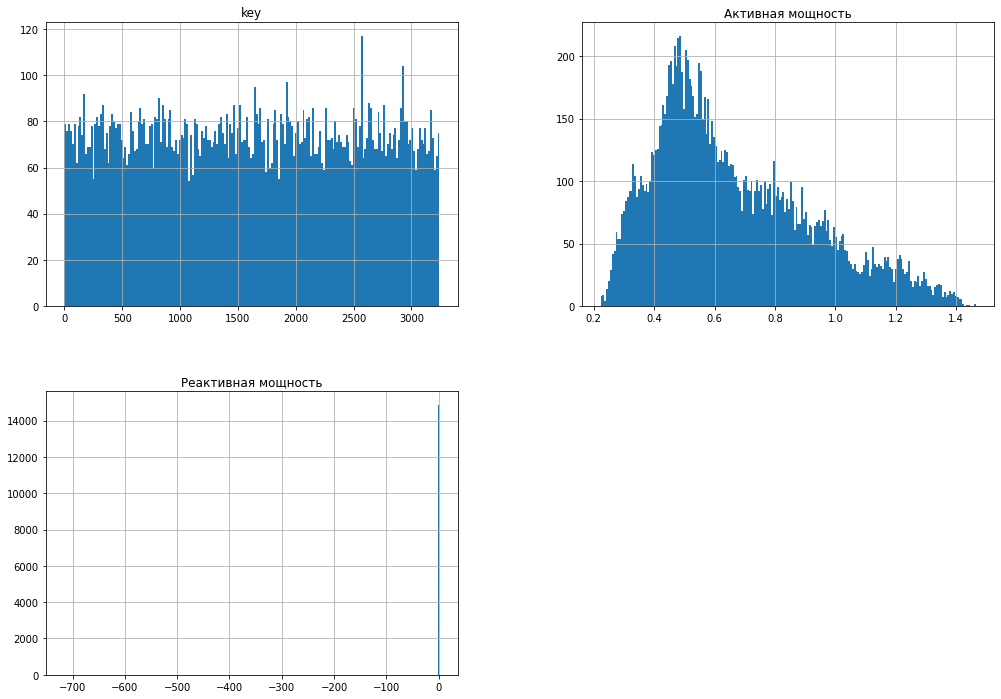

In [7]:
arc.hist(bins=200, figsize=(17,12));

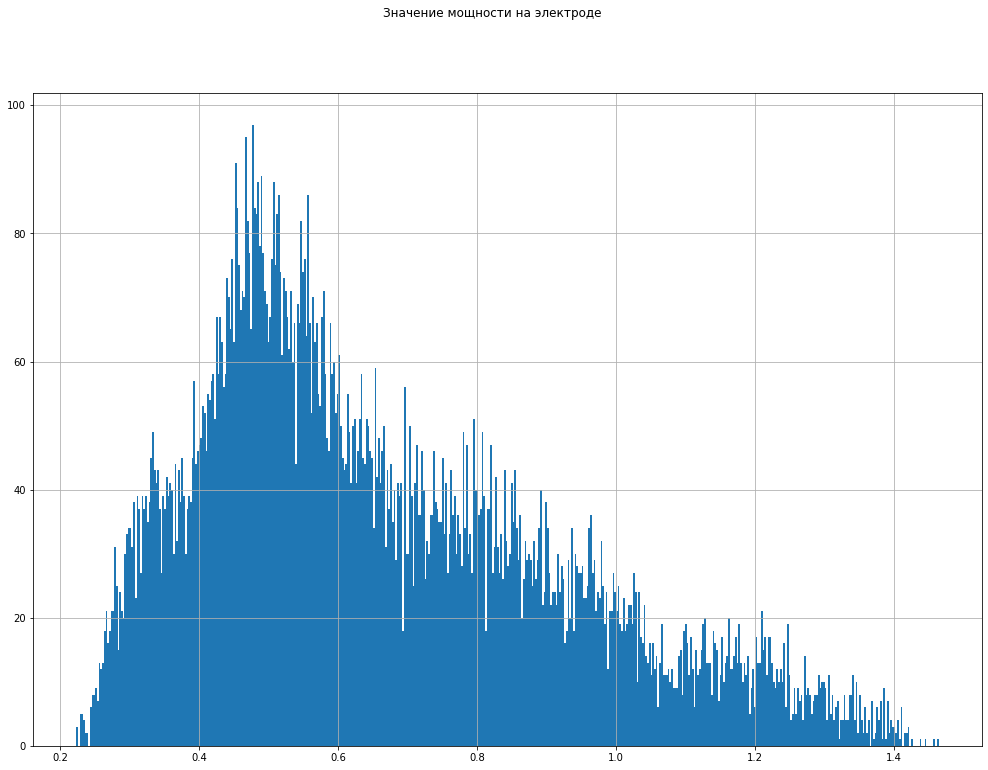

In [8]:
arc['Активная мощность'].hist(bins = 500,figsize=(17,12) );
plt.suptitle("Значение мощности на электроде");


Ключевой параметр данной таблицы - активная мощность. Активная мощность имеет распределение, близкое к нормальному, со скосом впаво, что говорит нам о - превышенная мощность встречается чаще 

Так же стоит отметить key - ункальный номер сплава


*На этапе предобработки данных имеет сымсл расчитать время работы дуги и оперировать этим показателем*

**Вопрос заказчику:** Как взаимодействуют активная и реактивная мощности, можно ли ихз превести к единой переменной, иными словами насколько корректно будет сложить\перемножить или производить иные действия с данными значениями для получения общего коэфициента?

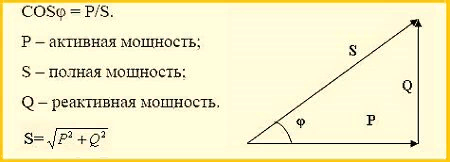

### Данные о подаче сыпучих материалов (объём). bulk

In [9]:
bulk.head(10)

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0
5,6,NaN,NaN,NaN,117.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,204.0,NaN,201.0,154.0
6,7,NaN,NaN,NaN,117.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,204.0,NaN,152.0,154.0
7,8,NaN,NaN,NaN,99.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,410.0,NaN,252.0,153.0
8,9,NaN,NaN,NaN,117.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,107.0,NaN,99.0,203.0
9,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,102.0,204.0


In [10]:
bulk_time.head(10)

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,2019-05-03 11:28:48,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:24:31,NaN,2019-05-03 11:14:50,2019-05-03 11:10:43
1,2,NaN,NaN,NaN,2019-05-03 11:36:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:53:30,NaN,2019-05-03 11:48:37,2019-05-03 11:44:39
2,3,NaN,NaN,NaN,2019-05-03 12:32:39,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:27:13,NaN,2019-05-03 12:21:01,2019-05-03 12:16:16
3,4,NaN,NaN,NaN,2019-05-03 12:43:22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:58:00,NaN,2019-05-03 12:51:11,2019-05-03 12:46:36
4,5,NaN,NaN,NaN,2019-05-03 13:30:47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:30:47,NaN,2019-05-03 13:34:12,2019-05-03 13:30:47
5,6,NaN,NaN,NaN,2019-05-03 13:57:27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:48:52,NaN,2019-05-03 14:09:42,2019-05-03 14:03:15
6,7,NaN,NaN,NaN,2019-05-03 14:18:58,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 14:41:26,NaN,2019-05-03 14:30:50,2019-05-03 14:27:16
7,8,NaN,NaN,NaN,2019-05-03 15:17:58,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 15:17:58,NaN,2019-05-03 15:13:18,2019-05-03 15:05:33
8,9,NaN,NaN,NaN,2019-05-03 16:03:08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 16:03:08,NaN,2019-05-03 16:00:16,2019-05-03 15:52:39
9,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 16:38:11,NaN,2019-05-03 16:34:24,2019-05-03 16:29:56


In [11]:
bulk_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   key      3129 non-null   int64 
 1   Bulk 1   252 non-null    object
 2   Bulk 2   22 non-null     object
 3   Bulk 3   1298 non-null   object
 4   Bulk 4   1014 non-null   object
 5   Bulk 5   77 non-null     object
 6   Bulk 6   576 non-null    object
 7   Bulk 7   25 non-null     object
 8   Bulk 8   1 non-null      object
 9   Bulk 9   19 non-null     object
 10  Bulk 10  176 non-null    object
 11  Bulk 11  177 non-null    object
 12  Bulk 12  2450 non-null   object
 13  Bulk 13  18 non-null     object
 14  Bulk 14  2806 non-null   object
 15  Bulk 15  2248 non-null   object
dtypes: int64(1), object(15)
memory usage: 391.2+ KB


In [12]:
bulk_time['key'].value_counts()

2049    1
2612    1
2588    1
541     1
2590    1
       ..
1090    1
3139    1
1092    1
3141    1
2047    1
Name: key, Length: 3129, dtype: int64

*key - уникальеный параметр таблиц BULK по которому можно и нужно будет итерироваться в дальнейшем*

В датасетах указан обьем сыпучих матерьялов и время их фактического добавления в общий обьем сплава. 
Исходя из указанного времени, отсчет этапов обратен нумерации, т.е. сначала bulk15, в конце bulk 1

Иными словами, сплав 1 (key1) - сформирован четырмя этапами 

* 2019-05-03 11:10:43  - 154.0 (ед.веса)
* 2019-05-03 11:14:50  - 150.0 (ед.веса)    
* 2019-05-03 11:24:31  - 206.0 (ед.веса)
* 2019-05-03 11:28:48  - 43.0  (ед.веса)

**Вопрос заказчику:** значение времени при подаче новых материлов технологически обусловлено? какие должны быть корректные показатели между этапами и от чего они зависят?

### Данные о продувке сплава газом. gas

In [13]:
gas.head(10)

,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692
5,6,11.273392
6,7,9.836267
7,8,15.171553
8,9,8.216623
9,10,6.529891


In [14]:
print(gas.info())
print("______________________________")
print("______________________________")
print(gas.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   Газ 1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB
None
______________________________
______________________________
               key        Газ 1
count  3239.000000  3239.000000
mean   1621.861377    11.002062
std     935.386334     6.220327
min       1.000000     0.008399
25%     812.500000     7.043089
50%    1622.000000     9.836267
75%    2431.500000    13.769915
max    3241.000000    77.995040


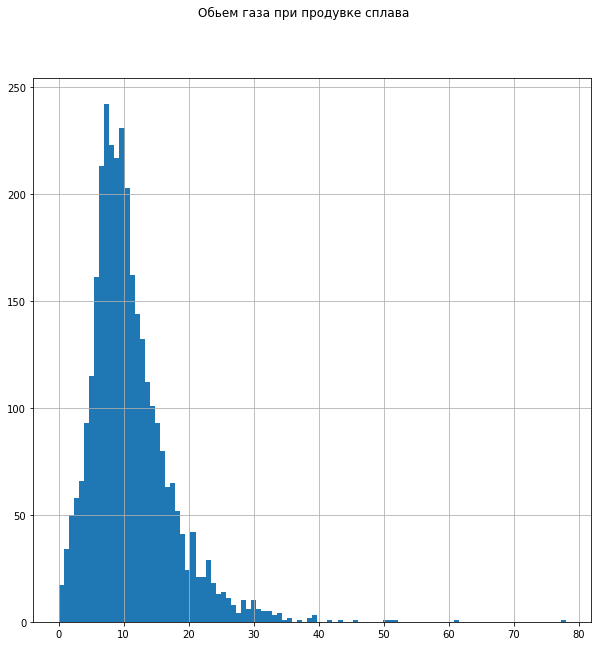

In [15]:
gas['Газ 1'].hist(bins = 100, figsize = (10, 10))
plt.suptitle("Обьем газа при продувке сплава");


Имеет нормальное распределение с закономерным скосом вправо, предположительно обусловленным настройкой оборудования взаимосвязи "больше температура  - больше\дольше\обьемнее продувка" (*требует уточнения*)

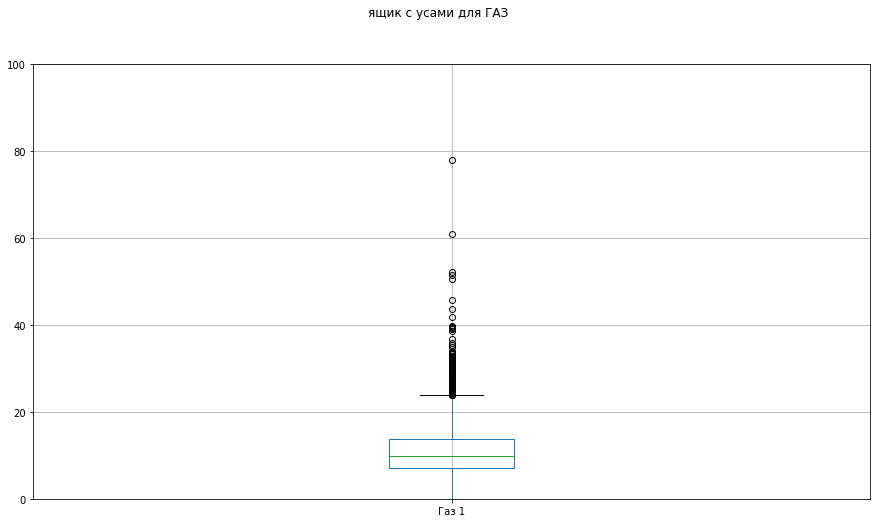

In [16]:
gas.boxplot(column = ['Газ 1'],
    figsize = (15,8));
plt.ylim([0,100]);
plt.suptitle("ящик с усами для ГАЗ");

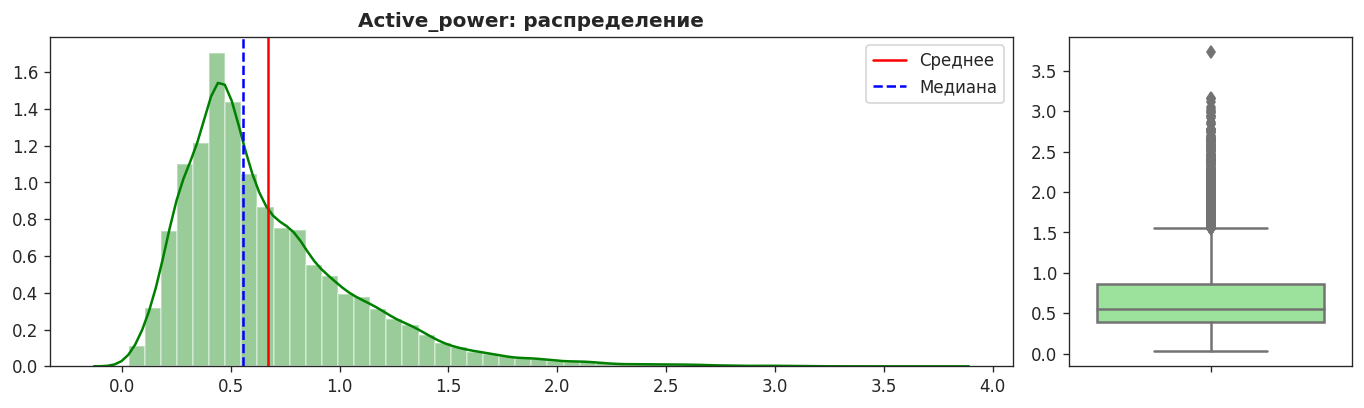

### Результаты измерения температуры

In [17]:
temp.head(10)

,key,Время замера,Температура
0,1,2019-05-03 11:02:04,1571.0
1,1,2019-05-03 11:07:18,1604.0
2,1,2019-05-03 11:11:34,1618.0
3,1,2019-05-03 11:18:04,1601.0
4,1,2019-05-03 11:25:59,1606.0
5,1,2019-05-03 11:30:38,1613.0
6,2,2019-05-03 11:34:04,1581.0
7,2,2019-05-03 11:38:40,1577.0
8,2,2019-05-03 11:46:09,1589.0
9,2,2019-05-03 11:49:38,1604.0


In [18]:
print(temp.info())
print("______________________________")
print("______________________________")
print(temp['Температура'].describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18092 entries, 0 to 18091
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           18092 non-null  int64  
 1   Время замера  18092 non-null  object 
 2   Температура   14665 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 424.2+ KB
None
______________________________
______________________________
count    14665.000000
mean      1590.722741
std         20.394381
min       1191.000000
25%       1580.000000
50%       1590.000000
75%       1599.000000
max       1705.000000
Name: Температура, dtype: float64


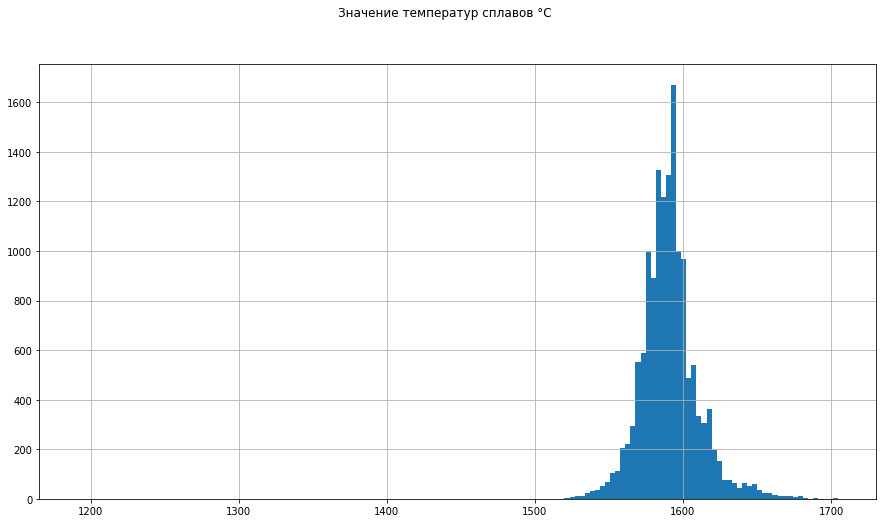

In [19]:
temp['Температура'].hist(bins = 150, figsize = (15,8));
plt.suptitle("Значение температур сплавов °C");

In [20]:
temp['key'].value_counts()

2108    17
1513    16
1689    16
2567    15
322     14
        ..
556      2
1169     2
732      2
195      1
279      1
Name: key, Length: 3216, dtype: int64

**Вопрос заказчику:** в каких случаях измерялась температура? в связи с чем по некоторым сплавам произведено 14 и более замеров, а по каким-то 1?

Температурные показатели имеют нормальное распределение, однако стоимт заметить что разброс температуры,от минимального до максимального значений, близок 600 градусов, при среднем значении температуры 1590 это порядка 35%. Возникаем вопрос чем обусловлен такой разрыв

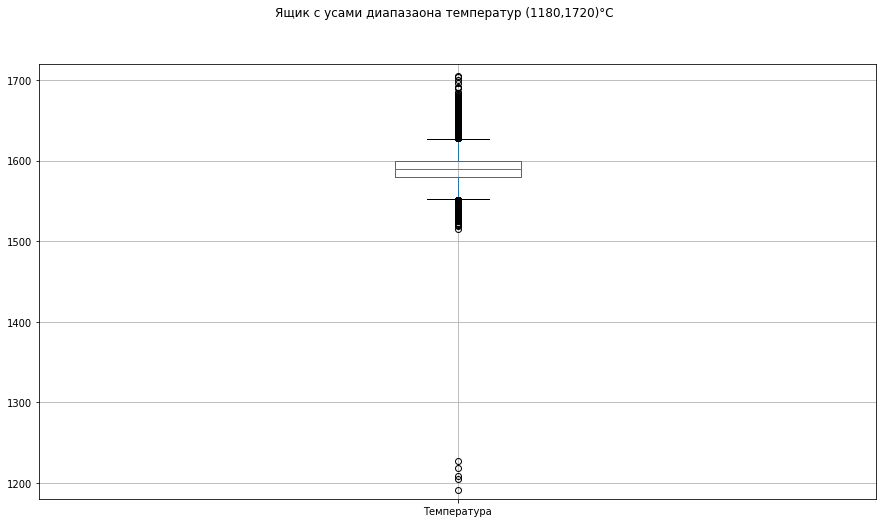

In [21]:
temp.boxplot(column= ['Температура'], 
    figsize = (15,8));
plt.ylim([1180,1720]);
plt.suptitle("Ящик с усами диапазаона температур (1180,1720)°C");

На графике хорошо видно что часть значений с показателями в диапозоне [1100,1300] - весьма справделиво считать выбросом в таком случае, интерпретированное мной, распределение температур выглядит примерно так :

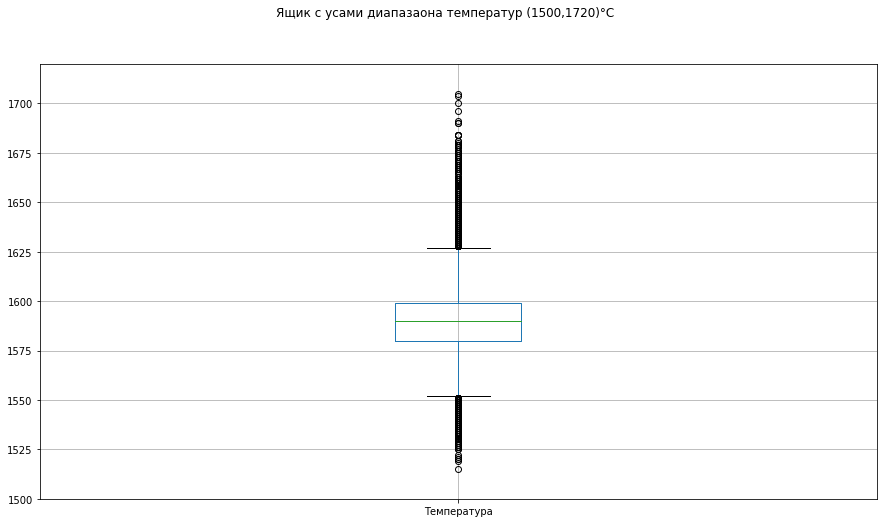

In [22]:
temp.boxplot(column= ['Температура'],
    figsize = (15,8));
plt.ylim([1500,1720]);
plt.suptitle("Ящик с усами диапазаона температур (1500,1720)°C");

*На этапе предобработки стоит избавиться от подобных "хвостов" т.к. они фактически являются выбросом .*

### Данные о проволочных материалах (объём)

In [23]:
wire.head(10)

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.114560,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,6,99.109917,9.114560,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,7,98.061600,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,8,155.282394,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,9,113.393279,9.143681,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,10,81.244796,12.376000,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [24]:
wire.describe()

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
count,3081.000000,3055.000000,1079.000000,63.000000,14.000000,1.000,73.000000,11.000000,19.000000,29.000000
mean,1623.426485,100.895853,50.577323,189.482681,57.442841,15.132,48.016974,10.039007,53.625193,34.155752
std,932.996726,42.012518,39.320216,99.513444,28.824667,NaN,33.919845,8.610584,16.881728,19.931616
min,1.000000,1.918800,0.030160,0.144144,24.148801,15.132,0.034320,0.234208,45.076721,4.622800
25%,823.000000,72.115684,20.193680,95.135044,40.807002,15.132,25.053600,6.762756,46.094879,22.058401
50%,1619.000000,100.158234,40.142956,235.194977,45.234282,15.132,42.076324,9.017009,46.279999,30.066399
75%,2434.000000,126.060483,70.227558,276.252014,76.124619,15.132,64.212723,11.886057,48.089603,43.862003
max,3241.000000,330.314424,282.780152,385.008668,113.231044,15.132,180.454575,32.847674,102.762401,90.053604


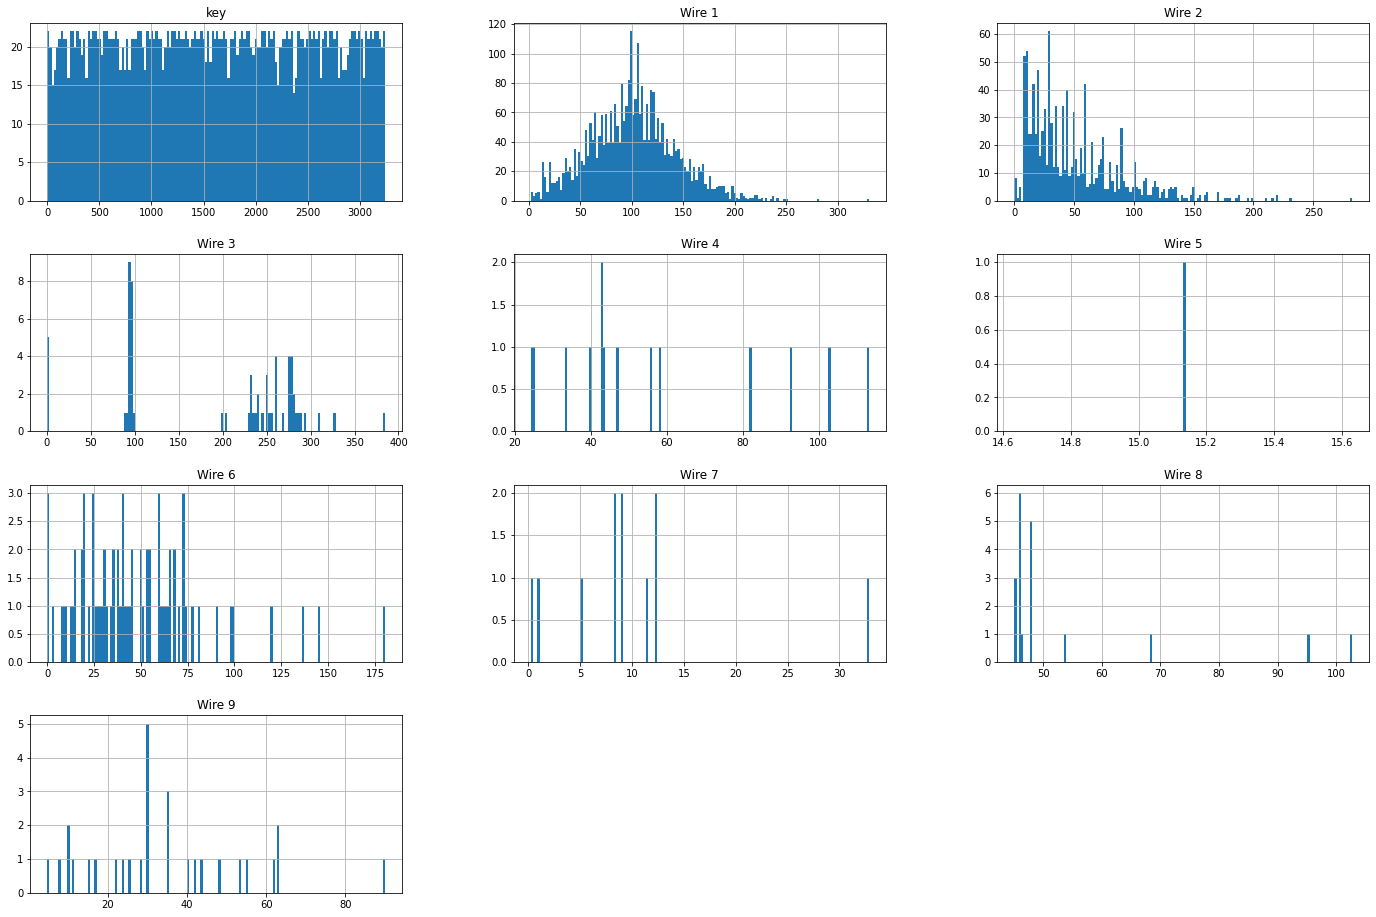

In [25]:
wire.hist(bins = 150, figsize = (24,16));

Значения имеют тенденцию к нормальному распределению, что отчетливо видно на "wire 1", wire 2-9 имели бы такой же граффический вид, все упирается в неполноту данных этих параметров



In [26]:
wire_time.head(10)

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:06:19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2019-05-03 11:36:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2019-05-03 12:11:46,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2019-05-03 12:43:22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2019-05-03 13:20:44,2019-05-03 13:15:34,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,6,2019-05-03 13:57:27,2019-05-03 13:48:52,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,7,2019-05-03 14:18:58,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,8,2019-05-03 15:01:30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,9,2019-05-03 15:45:44,2019-05-03 15:39:37,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,10,2019-05-03 16:27:00,2019-05-03 16:22:36,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [27]:
wire_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   key     3081 non-null   int64 
 1   Wire 1  3055 non-null   object
 2   Wire 2  1079 non-null   object
 3   Wire 3  63 non-null     object
 4   Wire 4  14 non-null     object
 5   Wire 5  1 non-null      object
 6   Wire 6  73 non-null     object
 7   Wire 7  11 non-null     object
 8   Wire 8  19 non-null     object
 9   Wire 9  29 non-null     object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB


### Вывод и дальнейшие действия:

После 1 этапа работ можно сделать следующие выводы:

* Столбцы на разных языках. Имена столбцов нужно превести к общепринятому виду (английским языком, прописными буквами и без пробелов).

* Во всех столбцах фреймов date необходим перевод времени в формат datetime.

* Целевым признаком будет последний замер температуры в temp для каждого key (партии)

* Пропуски в столбцах есть, однако в данной задаче не вижу смысла заниматься их выявлением и удалением в виду множества факторов. Пропуски это зачастую -  ошибка переноса, ошибка датчика или же просто остутсвие необходимости в проведении действия (нагрев, добавка присадок и пр.)

* Представленные данные в большинстве своем имеют нормальное или близкое к нормальному распределения

* Данные требуют групировки по нормеру партии key, также небходимо поправить все вышеперечисленные замечания.


*Так же во время проведения анализа скопился ряд вопросов касаемых технологии и процесса, они есть в конце каждого подпункта, но для удобства перенес их ниже*

<div class="alert" style="background-color:#e6e6fa;color:#8737bf">
    <font size="3"><b>Вопросы заказчику:</b></font>
    
*  Как взаимодействуют активная и реактивная мощности, можно ли их превести к единой переменной, иными словами насколько корректно будет сложить\перемножить или производить иные действия с данными значениями для получения общего коэфициента?  
    

* Значение времени при подаче новых материлов технологически обусловлено? какие должны быть корректные временные показатели между этапами и от чего они зависят?
    
    
* В каких случаях измерялась температура? в связи с чем по некоторым сплавам произведено 14 и более замеров, а по каким-то 1?    
    
</div>


## Предобрадотка данных

Чуть более детально по лану на этом этапе:
* Приведем данные в "рабочий вид", изменив наименования столбцов и исправив типы данных
* Добавим необходимые для расчетов столбцы 
* Сформируем единую таблицу данных на основании информауции о номере партии "key"
* Обьявим целевой показатель необходимой переменной
* Разобьем данные на выборки, необходимые для обучения и последующей проверки моделей расчета температуры



### Проверка типов данных

*Основная проблема в типах данных это значения даты записанные в формате object, исправляем:*

In [28]:
arc['Начало нагрева дугой'] = pd.to_datetime(arc['Начало нагрева дугой'])
arc['Конец нагрева дугой'] = pd.to_datetime(arc['Конец нагрева дугой'])

In [29]:
for i in bulk_time:
    bulk_time[i] = pd.to_datetime(bulk_time[i])

bulk_time['key'] = bulk_time['key'].astype(int)


In [30]:
for i in wire_time:
    wire_time[i] = pd.to_datetime(wire_time[i])

wire_time['key'] = wire_time['key'].astype(int)

### Подготовка данных

*Приведем столбцы в правильный вид для удобной работы с данными*

In [31]:
arc.columns = ['key', 'start_time','end_time', 'active_power', 'reactive_power']
bulk.columns = ['key', 'bulk_1','bulk_2','bulk_3','bulk_4','bulk_5','bulk_6','bulk_7','bulk_8',
                     'bulk_9','bulk_10','bulk_11','bulk_12','bulk_13','bulk_14','bulk_15']
bulk_time.columns = ['key', 'bulk_1','bulk_2','bulk_3','bulk_4','bulk_5','bulk_6','bulk_7','bulk_8',
                     'bulk_9','bulk_10','bulk_11','bulk_12','bulk_13','bulk_14','bulk_15']
gas.columns = ['key', 'gas_1']
temp.columns = ['key', 'time','temp']
wire.columns = ['key','wire_1','wire_2','wire_3','wire_4','wire_5','wire_6','wire_7','wire_8','wire_9']
wire_time.columns = ['key','wire_1','wire_2','wire_3','wire_4','wire_5','wire_6','wire_7','wire_8','wire_9']


Как и говорил ранее, отрицательные значения поля реактивная мощность - удаляем как выброс (1 значение)

In [32]:
arc = arc.query('reactive_power > 0')


In [33]:
arc.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14875 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   key             14875 non-null  int64         
 1   start_time      14875 non-null  datetime64[ns]
 2   end_time        14875 non-null  datetime64[ns]
 3   active_power    14875 non-null  float64       
 4   reactive_power  14875 non-null  float64       
dtypes: datetime64[ns](2), float64(2), int64(1)
memory usage: 697.3 KB


Добавим в датасет arс 2 колонки :

* Время нагрева heat_time
* Полную мощность power

In [34]:
arc["heat_time"] = arc['end_time'] - arc['start_time'] 
arc["power"] = np.sqrt(arc['active_power']**2 + arc['reactive_power']**2)

In [35]:
arc.head(6)

,key,start_time,end_time,active_power,reactive_power,heat_time,power
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253,0 days 00:03:48,0.371123
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438,0 days 00:03:05,0.902319
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460,0 days 00:02:52,0.722536
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979,0 days 00:06:05,0.642824
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691,0 days 00:02:28,1.079934
5,2,2019-05-03 11:34:14,2019-05-03 11:36:31,0.381124,0.220351,0 days 00:02:17,0.440239


In [36]:
arc_new = arc.groupby('key').agg(heat_time = ('heat_time', 'sum'), power = ('power', 'sum'))

Для выполнения следующего пункта 2.3  - необходимо привести таблицы к единому виду, или задать такую возможность с помощью доп.переменной. Иными словами нам необходимо выявить именно последний замер температур.


Так например в таблице **temp**, значения поля **key** повторяются многократно, сздадим отдельну. таблицу с данными где будут только максимальные и минимальные значения времени(последний замер) для каждого key т.е туда попадут первый и последний замер температур для ковша

Также помнинм, что необходимо утсранить хвост в данных

In [37]:
temp = temp[temp['temp'] > 1500 ]

In [38]:
#temp['key_last'] = temp.groupby(['key','temp'])['time'].transform(max)
temp.head(7)

,key,time,temp
0,1,2019-05-03 11:02:04,1571.0
1,1,2019-05-03 11:07:18,1604.0
2,1,2019-05-03 11:11:34,1618.0
3,1,2019-05-03 11:18:04,1601.0
4,1,2019-05-03 11:25:59,1606.0
5,1,2019-05-03 11:30:38,1613.0
6,2,2019-05-03 11:34:04,1581.0


In [39]:
last_temp = temp.sort_values('time', ascending=False).drop_duplicates(['key'])
last_temp.columns = ['key', 'last_time', 'last_temp',]
print(last_temp.sort_values('key'))
first_temp = temp.sort_values('time', ascending=True).drop_duplicates(['key'])
first_temp.columns = ['key', 'first_time', 'first_temp',]
print(first_temp.sort_values('key'))

        key            last_time  last_temp
5         1  2019-05-03 11:30:38     1613.0
10        2  2019-05-03 11:55:09     1602.0
16        3  2019-05-03 12:35:57     1599.0
21        4  2019-05-03 12:59:47     1625.0
26        5  2019-05-03 13:36:39     1602.0
...     ...                  ...        ...
18061  3237  2019-09-06 11:31:15     1569.0
18067  3238  2019-09-06 12:16:15     1584.0
18071  3239  2019-09-06 14:16:50     1598.0
18080  3240  2019-09-06 15:25:21     1617.0
18086  3241  2019-09-06 16:48:55     1586.0

[3215 rows x 3 columns]
        key           first_time  first_temp
0         1  2019-05-03 11:02:04      1571.0
6         2  2019-05-03 11:34:04      1581.0
11        3  2019-05-03 12:06:44      1596.0
17        4  2019-05-03 12:39:27      1601.0
22        5  2019-05-03 13:11:03      1576.0
...     ...                  ...         ...
18061  3237  2019-09-06 11:31:15      1569.0
18067  3238  2019-09-06 12:16:15      1584.0
18071  3239  2019-09-06 14:16:50      1598

In [40]:
last_temp.reset_index(drop=True)
first_temp.reset_index(drop=True)

,key,first_time,first_temp
0,1,2019-05-03 11:02:04,1571.0
1,2,2019-05-03 11:34:04,1581.0
2,3,2019-05-03 12:06:44,1596.0
3,4,2019-05-03 12:39:27,1601.0
4,5,2019-05-03 13:11:03,1576.0
...,...,...,...
3210,3237,2019-09-06 11:31:15,1569.0
3211,3238,2019-09-06 12:16:15,1584.0
3212,3239,2019-09-06 14:16:50,1598.0
3213,3240,2019-09-06 15:25:21,1617.0


In [41]:
total_temp = first_temp.merge(last_temp, how = 'left', on = 'key')
total_temp

,key,first_time,first_temp,last_time,last_temp
0,1,2019-05-03 11:02:04,1571.0,2019-05-03 11:30:38,1613.0
1,2,2019-05-03 11:34:04,1581.0,2019-05-03 11:55:09,1602.0
2,3,2019-05-03 12:06:44,1596.0,2019-05-03 12:35:57,1599.0
3,4,2019-05-03 12:39:27,1601.0,2019-05-03 12:59:47,1625.0
4,5,2019-05-03 13:11:03,1576.0,2019-05-03 13:36:39,1602.0
...,...,...,...,...,...
3210,3237,2019-09-06 11:31:15,1569.0,2019-09-06 11:31:15,1569.0
3211,3238,2019-09-06 12:16:15,1584.0,2019-09-06 12:16:15,1584.0
3212,3239,2019-09-06 14:16:50,1598.0,2019-09-06 14:16:50,1598.0
3213,3240,2019-09-06 15:25:21,1617.0,2019-09-06 15:25:21,1617.0


Также необходимо избавить от задвоенных показателей, чтобы целевой показатель не стал равен признаку


In [42]:
total_temp = total_temp[total_temp['first_time'] != total_temp['last_time'] ]
total_temp

,key,first_time,first_temp,last_time,last_temp
0,1,2019-05-03 11:02:04,1571.0,2019-05-03 11:30:38,1613.0
1,2,2019-05-03 11:34:04,1581.0,2019-05-03 11:55:09,1602.0
2,3,2019-05-03 12:06:44,1596.0,2019-05-03 12:35:57,1599.0
3,4,2019-05-03 12:39:27,1601.0,2019-05-03 12:59:47,1625.0
4,5,2019-05-03 13:11:03,1576.0,2019-05-03 13:36:39,1602.0
...,...,...,...,...,...
2472,2495,2019-08-10 11:27:47,1570.0,2019-08-10 11:50:47,1591.0
2473,2496,2019-08-10 11:56:48,1554.0,2019-08-10 12:25:13,1591.0
2474,2497,2019-08-10 12:37:26,1571.0,2019-08-10 12:53:28,1589.0
2475,2498,2019-08-10 12:58:11,1591.0,2019-08-10 13:23:31,1594.0


Пропуски значений заполняем (0)

In [43]:
bulk_time = bulk_time.fillna(0)
wire_time = wire_time.fillna(0)
bulk = bulk.fillna(0)
wire = wire.fillna(0)

### Формирование итоговых датафреймов

Создадим итоговый датасет из которого и будем выделять необходимые нам выборки

т.к. мы уже сгрупи

In [44]:
df = total_temp.sort_values('key')
df.reset_index(drop=True)

,key,first_time,first_temp,last_time,last_temp
0,1,2019-05-03 11:02:04,1571.0,2019-05-03 11:30:38,1613.0
1,2,2019-05-03 11:34:04,1581.0,2019-05-03 11:55:09,1602.0
2,3,2019-05-03 12:06:44,1596.0,2019-05-03 12:35:57,1599.0
3,4,2019-05-03 12:39:27,1601.0,2019-05-03 12:59:47,1625.0
4,5,2019-05-03 13:11:03,1576.0,2019-05-03 13:36:39,1602.0
...,...,...,...,...,...
2470,2495,2019-08-10 11:27:47,1570.0,2019-08-10 11:50:47,1591.0
2471,2496,2019-08-10 11:56:48,1554.0,2019-08-10 12:25:13,1591.0
2472,2497,2019-08-10 12:37:26,1571.0,2019-08-10 12:53:28,1589.0
2473,2498,2019-08-10 12:58:11,1591.0,2019-08-10 13:23:31,1594.0


In [45]:
df = df.merge(arc_new, how='inner', on ='key')

In [46]:
df = df.merge(gas, how = 'inner', on = 'key')

In [47]:
df = df.merge(bulk, how = 'inner', on = 'key')

In [48]:
#df = df.merge(bulk_time, how = 'left', on = 'key')

In [49]:
df = df.merge(wire, how = 'inner', on = 'key')

Также удалим значения  времени и нумерацию сплава (ковша), индекс в данном случае и будет нумерацией

In [50]:
df = df.drop(['key','first_time','last_time'], axis = 1)

Параметр  "время нагрева" переведем в другой тип данных для упрощения расчетов моделью

In [51]:
df['heat_time'] = df['heat_time'].astype(int)

### Проверка на мультиколлинеарность

Различные способы решения проблемы Мультиколлинеарности
*  Выбор переменных

Переменные следует выбирать таким образом, чтобы те, которые сильно коррелированы, были удалены, и мы использовали только значимые переменные.

* Преобразование переменных

Преобразование переменных является неотъемлемым шагом, и здесь цель состоит в том, чтобы сохранить функцию, но выполнение преобразования может дать нам диапазон, который не приведет к предвзятому результату.

* Анализ главных компонентов

Анализ основных компонентов — это метод уменьшения размерности, с помощью которого мы можем получить важные характеристики набора данных, которые сильно влияют на нашу целевую переменную.


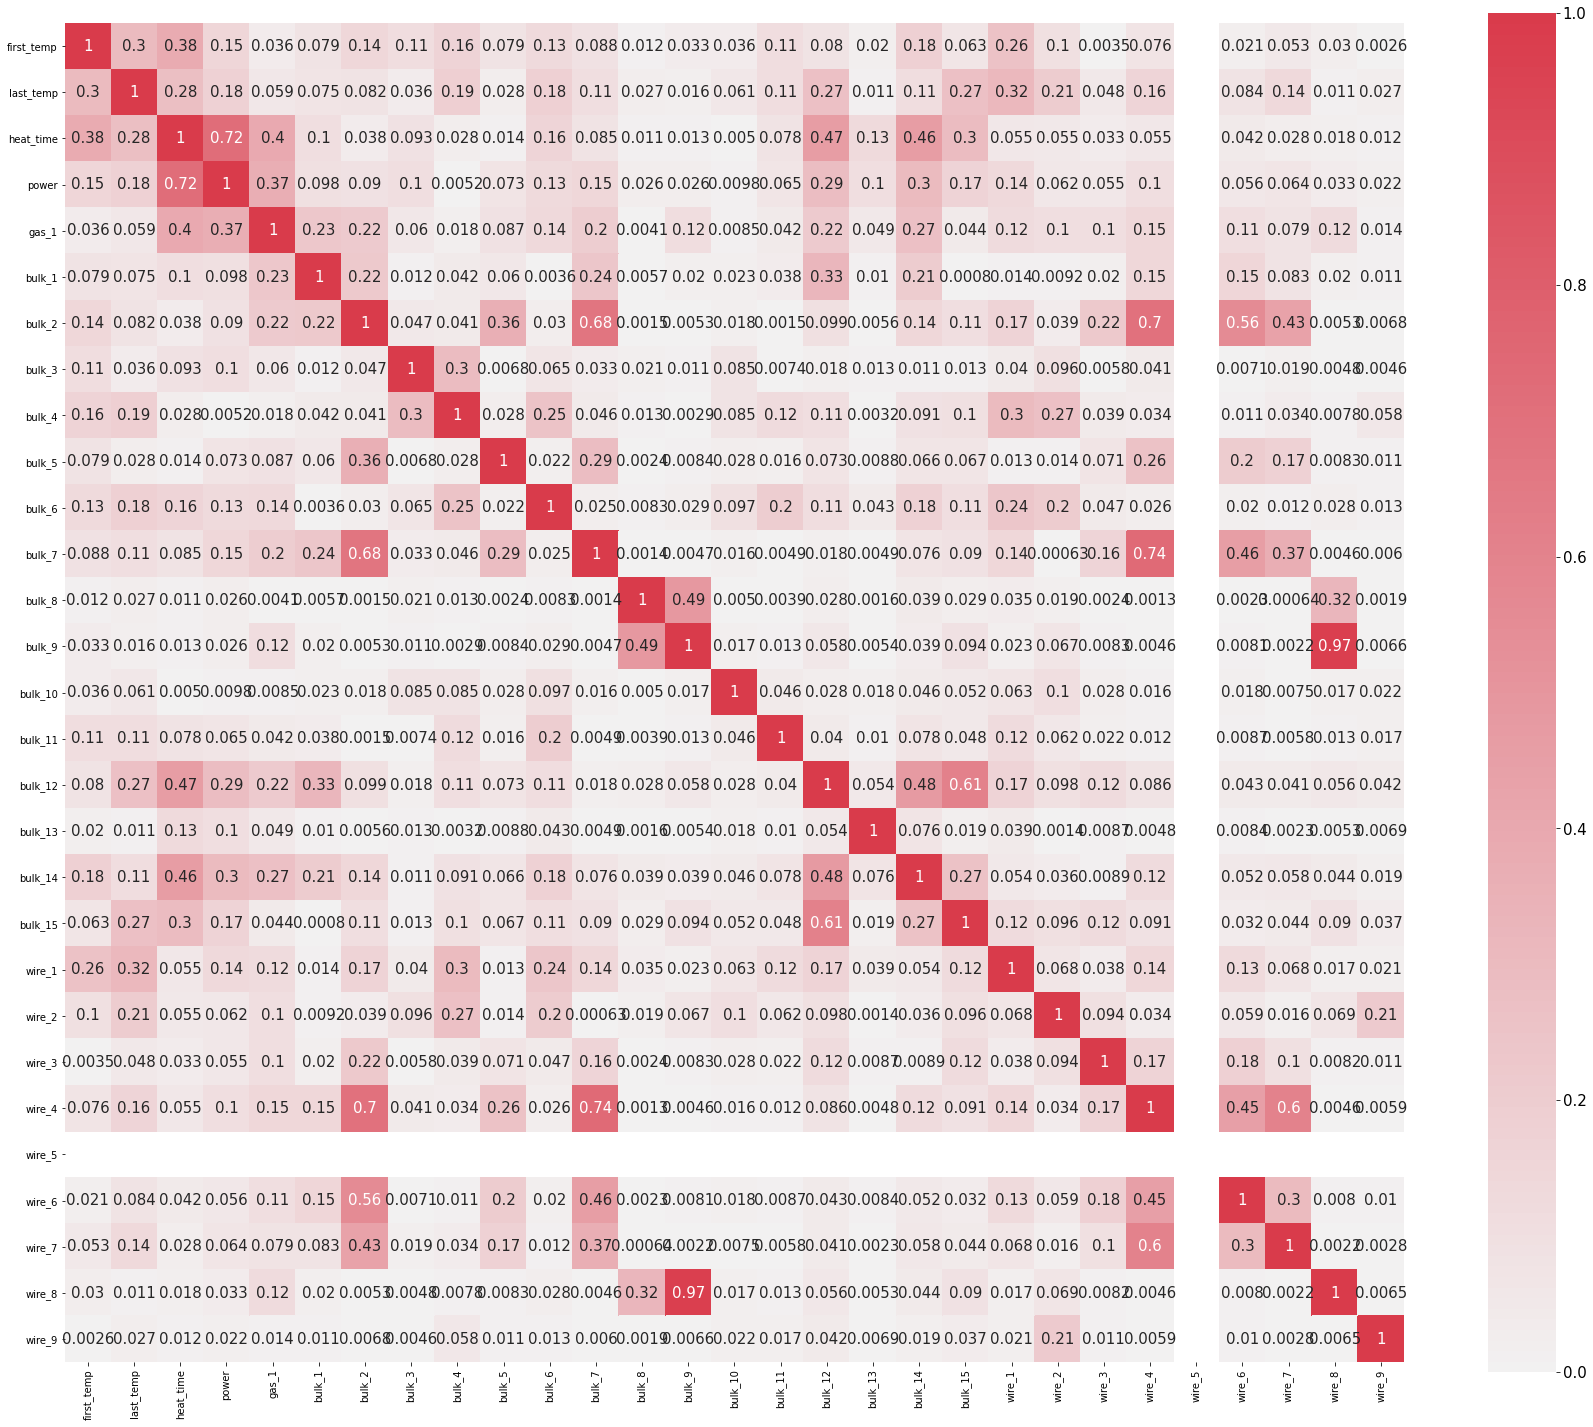

In [52]:
corr = abs(df.corr())

f, ax = plt.subplots(figsize=(30, 25))

font = {'size': 15}
plt.rc('font', **font)


cmap = sns.diverging_palette(200, 9, as_cmap=True)

ax = sns.heatmap(
    corr,         
#     mask=mask,    
    cmap=cmap,     
    annot=True,    
    vmax=1,       # The maximum value of the legend.
    vmin=0,      
    center=0,     
    square=True,   
    linewidths=0, 

    xticklabels=True, yticklabels=True
)

Исходя из полученного хитмапа - принимаю решение удалить из df параметры :

*корреляция на графике может принимать значения от   0  до  1*

Исходя из полученного хитмаапа можно наблюдать что корреляция будущего целевого признака - слабая положительная. 

Вероятно обосновано большим колличеством пропусков в данных. Стоит так же отметить показатели корреляции цпелевого признака от 0.009 (практически отсутвует взаимосвязь) до 0.98 (крайне большой показатель, 1 у идентичных параметров).

Это говорит нам о неравномерности данных


In [53]:
df = df.drop(['wire_5','wire_8'
#    'bulk_3','bulk_4','bulk_1','bulk_7','wire_6','bulk_11','wire_4','bulk_10','wire_3','bulk_5','bulk_13','wire_7','bulk_2','wire_9','wire_8','bulk_9','bulk_8',
    ], axis = 1)

### Формирвоание обучающией и тестовой выборок


In [54]:
df = df.fillna(0)

In [55]:
df

,first_temp,last_temp,heat_time,power,gas_1,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,...,bulk_13,bulk_14,bulk_15,wire_1,wire_2,wire_3,wire_4,wire_6,wire_7,wire_9
0,1571.0,1613.0,1098000000000,3.718736,29.749986,0.0,0.0,0.0,43.0,0.0,...,0.0,150.0,154.0,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0
1,1581.0,1602.0,811000000000,2.588349,12.555561,0.0,0.0,0.0,73.0,0.0,...,0.0,149.0,154.0,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0
2,1596.0,1599.0,655000000000,5.019223,28.554793,0.0,0.0,0.0,34.0,0.0,...,0.0,152.0,153.0,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0
3,1601.0,1625.0,741000000000,3.400038,18.841219,0.0,0.0,0.0,81.0,0.0,...,0.0,153.0,154.0,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0
4,1576.0,1602.0,869000000000,2.816980,5.413692,0.0,0.0,0.0,78.0,0.0,...,0.0,151.0,152.0,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2324,1570.0,1591.0,723000000000,3.868721,7.125735,0.0,0.0,21.0,0.0,0.0,...,0.0,129.0,223.0,89.150879,0.00000,0.0,0.0,0.0,0.0,0.0
2325,1554.0,1591.0,940000000000,5.070316,9.412616,0.0,0.0,0.0,63.0,0.0,...,0.0,129.0,226.0,114.179527,0.00000,0.0,0.0,0.0,0.0,0.0
2326,1571.0,1589.0,569000000000,4.360918,6.271699,0.0,0.0,0.0,85.0,0.0,...,0.0,124.0,226.0,94.086723,9.04800,0.0,0.0,0.0,0.0,0.0
2327,1591.0,1594.0,750000000000,3.909917,14.953657,0.0,0.0,90.0,0.0,0.0,...,0.0,129.0,207.0,118.110717,0.00000,0.0,0.0,0.0,0.0,0.0


In [56]:
random_state = 2062023
train, test = train_test_split(df, test_size = 0.25, random_state = random_state)

для дальнейшего использования в обучении моделей проведем масштабирование признаков

In [57]:
numeric = df.columns.tolist()
numeric = [i for i in numeric if i not in ("last_temp")]
scaler = MinMaxScaler()
scaler.fit(train[numeric])
train[numeric] = scaler.transform(train[numeric])
test[numeric] = scaler.transform(test[numeric])

### Целевой признак

In [58]:
feature_train = train.drop(['last_temp'], axis = 1)
target_train = train['last_temp']
feature_test = test.drop(['last_temp'], axis = 1)
target_test = test['last_temp']

### Вывод

На данном этапе мы подготовили данные к обучению моделей.

* Колонки в таблицах и данные в них приведены к "рабочему" формату
* Собрана единая таблица данных
* Произведен расчет корреляций параметров с последующим устранением аномалий
* Данные стандартизированы и  разбиты на необходимые выборки 
* Выделен целевой признак

В настоящий момент все готово для построения моделей машинного обучения, и расчета искомых показателей.

## Обучение моделей

В данном пункте мы рассмотрем обучение на наших данных 4х моделей: 

* LinearRegression

* RandomForestRegressor

* LightGBM

* CatBoostRegressor

Они имеют разную структуру и логику работы, что может повлиять на конечный результат.


Метрику, которой мы будем измерять качество их работы примем - MAE (Средняя абсолютная ошибка (англ. Mean Absolute Error) – это степень несоответствия между фактическими и прогнозируемыми значениями.)

**Основная задача раздела: МАЕ не должен превышать значение 6.8**

### LinearRegression

In [59]:

%%time

regressor = LinearRegression()
print('________________________')
print()
crossval_mae_lr = (cross_val_score(regressor, 
                             feature_train, 
                             target_train, 
                             cv=142, 
                             scoring='neg_mean_absolute_error').mean() * -1)
print(' Значение MAE на кросс-валидации для LinearRegression =', crossval_mae_lr)

________________________

 Значение MAE на кросс-валидации для LinearRegression = 6.257186847313088
CPU times: user 4.02 s, sys: 4.84 s, total: 8.86 s
Wall time: 8.8 s


Значение МАЕ на кросс-валидации  6.25, успешно.

### SGDRegressor

In [60]:
%%time
regressor = SGDRegressor(max_iter=1000,)
print('________________________')
print()
regressor.fit(feature_train, target_train )
cv_SGD = cross_val_score(regressor,
                      feature_train, 
                      target_train,
                      cv=123, 
                      verbose=0, 
                      scoring = 'neg_root_mean_squared_error').mean()*-1
print(' Значение MAE на кросс-валидации для SGDRegressor =',cv_SGD)

________________________

 Значение MAE на кросс-валидации для SGDRegressor = 8.251152356685619
CPU times: user 21.8 s, sys: 154 ms, total: 22 s
Wall time: 22.2 s


Модель LinearRegression не попала в необходимый диапазон


### CatBoostRegressor

In [61]:
%%time

regressor = CatBoostRegressor(verbose=False, random_state=random_state)
print('______________________________')
print()
cv_MAE_CBR = (cross_val_score(regressor, 
                             feature_train, 
                             target_train, 
                             cv= 12, 
                             scoring='neg_mean_absolute_error').mean() * -1)
print('Значение MAE на кроссвалидации для CatBoostRegressor =', cv_MAE_CBR)
print()
print("Значения наилчших параметров подбора для данных:")
print()
best_params_CBR = CatBoostRegressor(verbose=False, 
                                    random_state=random_state).fit(feature_train, 
                                        target_train).get_all_params()
best_params_CBR

______________________________

Значение MAE на кроссвалидации для CatBoostRegressor = 6.238445135786776

Значения наилчших параметров подбора для данных:

CPU times: user 36.9 s, sys: 1.16 s, total: 38 s
Wall time: 54.7 s


{'nan_mode': 'Min',
 'eval_metric': 'RMSE',
 'iterations': 1000,
 'sampling_frequency': 'PerTree',
 'leaf_estimation_method': 'Newton',
 'grow_policy': 'SymmetricTree',
 'penalties_coefficient': 1,
 'boosting_type': 'Plain',
 'model_shrink_mode': 'Constant',
 'feature_border_type': 'GreedyLogSum',
 'bayesian_matrix_reg': 0.10000000149011612,
 'force_unit_auto_pair_weights': False,
 'l2_leaf_reg': 3,
 'random_strength': 1,
 'rsm': 1,
 'boost_from_average': True,
 'model_size_reg': 0.5,
 'pool_metainfo_options': {'tags': {}},
 'subsample': 0.800000011920929,
 'use_best_model': False,
 'random_seed': 2062023,
 'depth': 6,
 'posterior_sampling': False,
 'border_count': 254,
 'classes_count': 0,
 'auto_class_weights': 'None',
 'sparse_features_conflict_fraction': 0,
 'leaf_estimation_backtracking': 'AnyImprovement',
 'best_model_min_trees': 1,
 'model_shrink_rate': 0,
 'min_data_in_leaf': 1,
 'loss_function': 'RMSE',
 'learning_rate': 0.04471199959516525,
 'score_function': 'Cosine',
 'task

Значение показателя MAE попадает в необходимые 6.8, однако "запас прочности" не самый большой.

### RandomForestRegressor

In [62]:
%%time

regressor = RandomForestRegressor() 
params = [{'criterion':['mse'],
                'n_estimators':[x for x in range(50, 1000, 50)], 
                'random_state':[random_state]}]

print('______________________________')
print()
clf = GridSearchCV(regressor, params, scoring='neg_mean_absolute_error', cv=5)
clf.fit(feature_train, target_train)
print("Значение лучших параметров:")
print()
best_params_RFR = clf.best_params_
print(clf.best_params_)
print()
print("Grid score:")
print()
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.6f for %r"% ((mean*-1), params))
print()

cv_MAE_RFR = (max(means)*-1)

______________________________

Значение лучших параметров:

{'criterion': 'mse', 'n_estimators': 100, 'random_state': 2062023}

Grid score:

6.349080 for {'criterion': 'mse', 'n_estimators': 50, 'random_state': 2062023}
6.324308 for {'criterion': 'mse', 'n_estimators': 100, 'random_state': 2062023}
6.334988 for {'criterion': 'mse', 'n_estimators': 150, 'random_state': 2062023}
6.328821 for {'criterion': 'mse', 'n_estimators': 200, 'random_state': 2062023}
6.326798 for {'criterion': 'mse', 'n_estimators': 250, 'random_state': 2062023}
6.328695 for {'criterion': 'mse', 'n_estimators': 300, 'random_state': 2062023}
6.330421 for {'criterion': 'mse', 'n_estimators': 350, 'random_state': 2062023}
6.329622 for {'criterion': 'mse', 'n_estimators': 400, 'random_state': 2062023}
6.328238 for {'criterion': 'mse', 'n_estimators': 450, 'random_state': 2062023}
6.329855 for {'criterion': 'mse', 'n_estimators': 500, 'random_state': 2062023}
6.327916 for {'criterion': 'mse', 'n_estimators': 550, 'ran

Лучшее значение MAE, при данном наборе данных, полученное на модели RandomForestRegressor - 5.874. 
Укладывается в заявленные ограничения.

### Данные на обучающей выборке

In [63]:
index = ['LinearRegression',
         'RandomForestRegressor',
         'CatBoostRegressor',
         'SGDRegressor'
        ]

data = {'MAE на обучении':[crossval_mae_lr,
                           cv_MAE_RFR,
                           cv_MAE_CBR,
                           cv_SGD
                           ]}

scores_data = pd.DataFrame(data=data, index=index)
scores_data['Выполнение задачи'] = scores_data['MAE на обучении'] <= 6.8
scores_data

,MAE на обучении,Выполнение задачи
LinearRegression,6.257187,True
RandomForestRegressor,6.324308,True
CatBoostRegressor,6.238445,True
SGDRegressor,8.251152,False


## Тестирование моделей

На данном этапе предоствим нашим обученным моделям случайный набор данных, для получения фактической точности более интересной в плане бизнесс модели.

В нашем случае это тестовая выборка, предложим ее моделям для предсказания и повторно замерим MAE

Ожидаемо значение должно незначительно отклонятся от показателей полученных на обучении.

### CatBoostRegressor

In [64]:

%%time

model = CatBoostRegressor(verbose=False)
model.set_params(**best_params_CBR)
model.fit(feature_train, target_train)
target_predict = model.predict(feature_test)
test_MAE_CBR = mean_absolute_error(target_predict, target_test)
print('MAE на тестовой выборке для CatBoostRegressor =', test_MAE_CBR)


MAE на тестовой выборке для CatBoostRegressor = 6.4266911076614806
CPU times: user 2.81 s, sys: 65.3 ms, total: 2.88 s
Wall time: 3.83 s


## Итоги проведенных работ

По итогу было выполнено:

Выстроен план работы

Изучены и подготовлены данные

На основе изученных данных стало понятно, что это задача регрессии

Далее мы предобработали данные, привели их в порядок, поработали с пропусками

Согласно физическам формуле начали считать полную мощность 

По итогу преобработанных данных начали формировать финальный датасет, проверив мультиколлинеарность

По колрреляционной матрице выявили факторы для удаления из таблицы в угоду недо/пере обучения

Создали обучающую и тестовую выборку для моделей с использованием масштабирования

Обучили такие регрессионные модели как: LinearRegression, RandomForest, CatBoost, SGDRegressor 

Запустили тестирование моделей на тест данных

Вывели итоговые значения качества моделей

### Важность факторов

In [65]:

importances = model.feature_importances_
feature_list = list(feature_train.columns)
feature_results = pd.DataFrame({'feature': feature_list,'importance': importances})
feature_results = feature_results.sort_values('importance',ascending = False).reset_index(drop=True)
feature_results

,feature,importance
0,heat_time,22.347655
1,first_temp,21.875449
2,wire_1,7.625464
3,bulk_15,6.011345
4,bulk_14,5.982450
5,gas_1,5.931833
6,bulk_6,5.903040
7,bulk_12,5.169908
8,power,5.147621
9,wire_2,4.277723


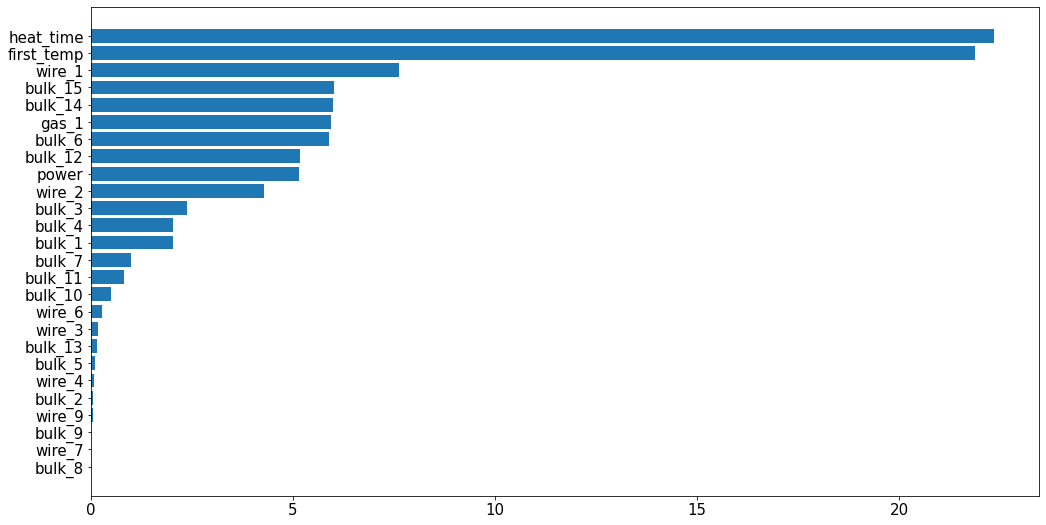

In [66]:

indices = np.argsort(importances)

fig, ax = plt.subplots(figsize=(17,9))
ax.barh(range(len(importances)), importances[indices])
ax.set_yticks(range(len(importances)))
_ = ax.set_yticklabels(np.array(feature_train.columns)[indices])

### Вывод



Видим что ценности для модели особне не представляют или не представляют совсем  

* Данные о подаче сыпучих материалов 
* данные о проволочных материалах

Наименее значимиые среди них: 

bulk_8, bulk_9, wire_9, wire_7,bulk_13,bulk_2,bulk_5,wire_3


Факторы с наибольшей значимостью влияния на точность предсказания 

* Время нагрева (heat_time)
* Первый замер температуры ковша (first_temp)


В ходе проекта было достигнуто необходимое качество, однако стоит заметить что при улучшении качества исходных данных, значимость факторов возрастет, следовательно возрастет и точность, стоит обратить на это внимание в случае необходимости улучшений

##  Общий вывод проекта


В ходе работы были обучены такие регрессионные модели как: Linear, RandomForest, CatBoost, SGDRegressor.

Лучшей моделью оказались LinearRegression c показателем MAE = 6.25, однако CatBoostRegressor MAE = 6.23  - успешно справилась с поставленной задачей, и время модели CatBoostRegressor быстрее почти в 1.5 раза, что может являться определяющем фактором при выборе одной модели.

Изходя из проведенного исследования для выполнения поставленной задачи можно использовать обе модели, определяющим фактором будет являться необходимость более точных значений (разница точности предсказний между моделями порядка 2% в пользу CatBoostRegressor) и скорости произведения вычислений.

Исходя из аналитического опыта, для решения данной проблемы рекомендую использовать модель CatBoostRegressor.


Также необходимо отметить, что для усовершенствования показаний качества необходимо устранить проблемы исходных данных для обучения моделей. (Подробнее в п. Итоги проведенных работ)

Основной проблемой можно назвать качество данных, очень много пропусков, нет соответсвия между замерами для каждой итерации  ковша(сплава) - обработки газом(время и обьем), данные о проволочных материалах (время и обьем)

В случае появления полных данных финальное значение отклонения при предсказании можно сократить до более выгодных значений

### Отчет

1.  **Какие пункты плана были выполнены, а какие — нет. Почему?**

*Изначально у меня был какой-то план и я его придерживался (с)*

Старался двигаться по опорному плану на всех этапах, т.к. он и нужен для того чтобы всегда понимать на каком этапе ты и что еще предстоит сделать. Из пропущенных пунктов - "анализ адекватности модели", отсечен по причине крайне схожих трендах показателей на всех моделях при изменении трейн сборки, что говорит о присутствии логики в работе моделей.

2.  **Какие трудности возникли и как вы их преодолели?**

Основная трудность конечно то, что при выполнении я был "не в ресурсе", сам процесс плавления метала изначально не очевиден - отсюда и вопросы к формированию измерений, и правильности дальнейших итераций. Ключевые вопросы были ликвидированы вопросами к заказчику, что с моей точки зрения правильный вариант работы.

3. **Какие ключевые шаги в решении задачи вы выделили?**

Ключевой шаг, как наверное и в любой задаче регрессии, формировании правильных трейн и таргет выборок. Соответственно фактически главной частью проекта является не обучение или тестирование моделей, а именно предобработка данных.

4. **Какие признаки использовали для обучения модели и какая предобработка этих признаков была выполнена?**

Какие признаки? - ответ на данный вопрос развернуто в 5.2 там я провожу анализ важности факторов. 
Вот выжимка касательно ключевых признаков:

"
*Факторы с наибольшей значимостью влияния на точность предсказания* 

* *Время нагрева (heat_time)*
* *Первый замер температуры ковша (first_temp)*
"

5. **Какая ваша итоговая модель, какие у неё гиперпараметы и какое качество?**

На обучающей выборке значение МАЕ 3х из 4х моделей было крайне схожим (*было очень странно получить показания на SGD хуже чем на LinReg и еще более странно получить LightGBM который обучался более 2х часов в виду чего был уничтожен), но тем не менее предпочтение отдавал по критериям, сначала точность, а потом скорость решения. ( на тесте проверял все конечно, хоть мне и уместно намекнули, что это *mauvais ton*))) 

Данные на трейне:
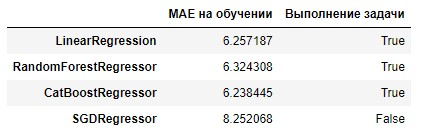


Таким образом выбран был  CatBoost, вот его значения и параметры:


_______________________________________________________________

MAE на тестовой выборке для CatBoostRegressor = 6.4266911076614806

CPU times: user 2.81 s, sys: 65.3 ms, total: 2.88 s

Wall time: 3.83 s
_______________________________________________________________

Best params: 

* 'nan_mode': 'Min',
* 'eval_metric': 'RMSE',
* 'iterations': 1000,
* 'sampling_frequency': 'PerTree',
* 'leaf_estimation_method': 'Newton',
* 'grow_policy': 'SymmetricTree',
* 'penalties_coefficient': 1,
* 'boosting_type': 'Plain',
* 'model_shrink_mode': 'Constant',
* 'feature_border_type': 'GreedyLogSum',
* 'bayesian_matrix_reg': 0.10000000149011612,
* 'force_unit_auto_pair_weights': False,
* 'l2_leaf_reg': 3,
* 'random_strength': 1,
* 'rsm': 1,
* 'boost_from_average': True,
* 'model_size_reg': 0.5,
* 'pool_metainfo_options': {'tags': {}},
* 'subsample': 0.800000011920929,
* 'use_best_model': False,
* 'random_seed': 2062023,
* 'depth': 6,
* 'posterior_sampling': False,
* 'border_count': 254,
* 'classes_count': 0,
* 'auto_class_weights': 'None',
* 'sparse_features_conflict_fraction': 0,
* 'leaf_estimation_backtracking': 'AnyImprovement',
* 'best_model_min_trees': 1,
* 'model_shrink_rate': 0,
* 'min_data_in_leaf': 1,
* 'loss_function': 'RMSE',
* 'learning_rate': 0.04471199959516525,
* 'score_function': 'Cosine',
* 'task_type': 'CPU',
* 'leaf_estimation_iterations': 1,
* 'bootstrap_type': 'MVS',
* 'max_leaves': 64}